In [101]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM, Activation, Input
from keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [102]:
df = pd.read_csv('../data/asfp_cleaned_features.csv')
cols = df.columns.values
print(cols)

['time' 'sensor' 'water_temp' 'ph' 'ec' 'do' 'dt_seconds' 'segment' 'hour'
 'dayofweek' 'month' 'water_temp_roll1h_mean' 'ph_roll1h_mean'
 'ec_roll1h_mean' 'do_roll1h_mean']


In [105]:
df_sub = df[df['sensor'] == 1].iloc[5:12000]

In [ ]:
######################
#### Split Data #####
######################

X_train, X_test = train_test_split(df_sub, test_size=0.2, shuffle=False) #Keep data in sequential order when splitting
df_train = X_train.reset_index() #Reset index for cleanliness
df_test = X_test.reset_index() #Reset index for cleanliness

In [ ]:
############################
#### Scale Features ########
############################

feature_cols = ['water_temp', 'ph', 'ec', 'do', 'dt_seconds', 'segment', 'hour', 'dayofweek', 'month', 'water_temp_roll1h_mean', 'ph_roll1h_mean', 'ec_roll1h_mean', 'do_roll1h_mean']

scaler = MinMaxScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

In [ ]:
######################
#### Design Model ####
######################

input_features = ['water_temp', 'ph', 'ec', 'do']
output_features = ['water_temp', 'ph', 'ec', 'do']

n_inputs = len(input_features)
n_outputs = len(output_features)  

layer_1_units = 32
layer_2_units = 16

dropout_rate = 0.1
learning_rate = 0.01

optimizer = Adam(learning_rate)
loss='mean_squared_error'
metrics=['mse']

batch_size = 500
validation_split = 0.05

seq_length = 20 #100 mins
pred_horizon = 6 #30 mins

seq_arrays = []
seq_labels = []

#Create list of sequence length readings for all model features
for i in range(len(df_train) - seq_length - pred_horizon):
    seq_arrays.append(df_train[input_features].iloc[i:i+seq_length].values) 
    seq_labels.append(df_train[output_features].iloc[i+seq_length+pred_horizon].values) 

#Convert to numpy arrays before checking shape
seq_arrays = np.array(seq_arrays)
seq_labels = np.array(seq_labels)

#Check shape of sequences
assert seq_arrays.shape == (len(df_train) - seq_length - pred_horizon, seq_length, len(input_features))
assert seq_labels.shape == (len(df_train) - seq_length - pred_horizon, len(output_features))

In [ ]:
######################
#### Build Model ####
######################

model = Sequential(name='lstm_hydro')

#Input Layer
model.add(Input(shape=(seq_length, n_inputs)))

#First Hidden Layer
model.add(LSTM(
    name='lstm_1',
    units=layer_1_units, 
    return_sequences=True) # Return full sequence for next LSTM layer
)
model.add(Dropout(dropout_rate, name='dropout_1'))

#Second Hidden Layer
model.add(LSTM(
    name='lstm_2',
    units=layer_2_units, 
    return_sequences=False) # Return final output only for regression
)
model.add(Dropout(dropout_rate, name='dropout_2'))

#Output Layer
model.add(Dense(units=n_outputs, name='output')) # Fully connected linear layer

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

In [110]:
#Fit the network
history = model.fit(
    seq_arrays, 
    seq_labels, 
    epochs=100, 
    batch_size=batch_size, 
    validation_split=validation_split, 
    verbose=2, 
    callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')]
)

Epoch 1/100
19/19 - 1s - 63ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 2/100
19/19 - 0s - 15ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 3/100
19/19 - 0s - 15ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 4/100
19/19 - 0s - 15ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/100
19/19 - 0s - 15ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/100
19/19 - 0s - 15ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/100
19/19 - 0s - 15ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 8/100
19/19 - 0s - 15ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 9/100
19/19 - 0s - 15ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 10/100
19/19 - 0s - 15ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0016 - val_m

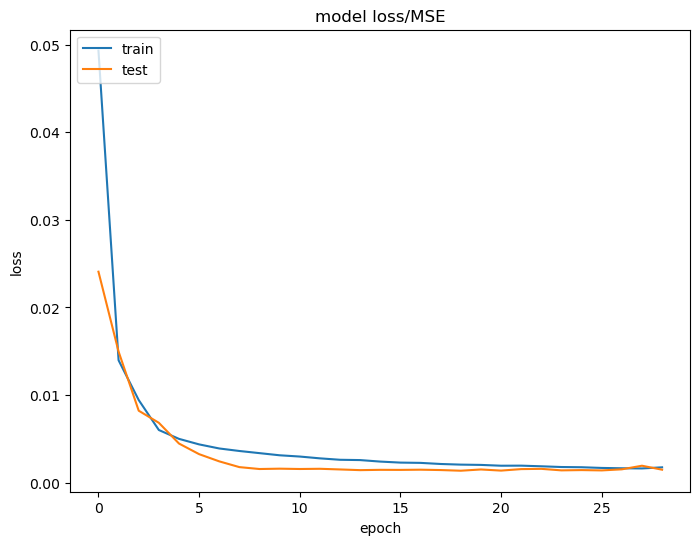

In [ ]:
#Plot history for MSE Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [ ]:
########################
#### Validate Model ####
########################

test_arrays = []
test_labels = []

for i in range(2, len(df_test) - pred_horizon):
    start_idx = max(0, i - seq_length)
    seq = df_test[input_features].iloc[start_idx:i].values
    test_arrays.append(seq)
    test_labels.append(df_test[output_features].iloc[i + pred_horizon].values)

test_arrays = pad_sequences(test_arrays, maxlen=seq_length, dtype='float32', padding='pre')

test_labels = np.array(test_labels, dtype=np.float32)

In [ ]:
########################
#### Evaluate & Plot ####
########################

scores_test = model.evaluate(test_arrays, test_labels, verbose=2)
print('\nTest MSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(test_arrays)
y_true_test = test_labels

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(output_features):
    ax = axes[i]
    ax.plot(y_true_test[:, i], label='Actual')
    ax.plot(y_pred_test[:, i], label='Predicted')
    ax.set_title(f'{feat}')
    ax.set_xlabel('Row')
    ax.set_ylabel('Scaled Value')
    ax.legend()

plt.tight_layout()
plt.show()